# Comparative metagenomics at community-level

## Normalization methods and alpha & beta diversity

This is an interactive code notebook (a Jupyter Notebook). To run this code, click into each cell and press the ▶ button in the top toolbar, or press shift+enter

MGnifyR is a library that provides a set of tools for easily accessing and processing MGnify data in R making queries to MGnify databases through the [MGnify API](https://www.ebi.ac.uk/metagenomics/api/v1/). A huge benefit of using this tool is that data can either be fetched in tsv format or be directly combined in a phyloseq object to run an analysis in a custom workflow.

In this example we aim to demonstrate how the MGnifyR tool can be used to fetch data and metadata of a MGnify metagenomic analyisis. Then we will show how to generate diversity metrics for comparative metagenomics using taxonomic profiles.

## Contents
- [Part 1. Fetch data from MGnify using MGnifyR, explore metadata and build a phyloseq object](#part1)
  - [1.1. Fetch the MGnify Analyses accession](#part1_1)
  - [1.2. Explore and filter samples by metadata](#part1_2)
  - [1.3. Converting into phyloseq object](#part1_3)
- [Part 2. Normalization, alpha diversity indices and taxonomic profiles visualization](#part2)
   - [2.1. Cleaning the OTUs matrix](#part2_1)
   - [2.2. Normalization by total sum scaling (TSS, relative abundance or proportions)](#part2_2)
   - [2.3. Normalization by subsampling (rarefaction)](#part2_3)
   - [2.4. Normalization by cumulative sum scaling (CSS)](#part2_4)
- [Part 3. Comparative metagenomics at community-level: Beta diversity](#part3)
- [References](#refs)

In [1]:
library(IRdisplay)
#display_markdown(file = '../_resources/mgnifyr_help.md')

Loading libraries:

In [2]:
library(stringr)
library(vegan)
library(ggplot2)
library(phyloseq)
library(metagenomeSeq)
library(MGnifyR)
library(microbiomeMarker)
library(plyr)

mg = mgnify_client(usecache = T, cache_dir = '/home/jovyan/.mgnify_cache')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘Biobase’


The following object is maske

Setting tables and figures size to display (these will be reset later):

In [3]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
options(repr.plot.width=6, repr.plot.height=6)

## Part 1. Fetch data from MGnify using MGnifyR, explore metadata and build a phyloseq object <a id='part1'/>

In this example we are going to fetch MGnify analysis results and metadata for TARA ocean metagenomic study corresponding to size fractions for prokaryotes ([MGYS00002008](https://www.ebi.ac.uk/metagenomics/studies/MGYS00002008#overview)).
Find more information about the [TARA Ocean Project.](https://fondationtaraocean.org/en/expedition/tara-oceans/)

### 1.1. Fetch the MGnify Analyses accession <a id='part1_1'/>

The first step is to retrieve the analysis accession list.

In [4]:
tara_all = mgnify_analyses_from_studies(mg, 'MGYS00002008')

  |======================================================================| 100%


And use this list to fetch the metadata for all of the analyses from the MGnify API.

In [5]:
metadata = mgnify_get_analyses_metadata(mg, tara_all)
#head(metadata)

  |======================================================================| 100%


Note: In case you are intereseted in running the comparative metagenomic analysis using data from different studies in MGnify, you can adapt the following commands:


analyses_accessions = mgnify_analyses_from_studies(mg, c("MGYS1","MGYS2"))

metadata = mgnify_get_analyses_metadata(mg, analyses_accessions)

### 1.2. Explore and filter samples by metadata <a id='part1_2'/>

We want to keep only metagenomic samples (no amplicon) of 'surface water layer ([ENVO:00002042](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00002042))' and 'mesopelagic zone ([ENVO:00000213](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00000213))' to compare. We also want to filter out results generated with old pipeline versions (<V5.0). In the following steps we will filter out non-interested samples before exporting to the phyloseq object. Let's explore a bit the metadata file first:

1) Check the number of analysis in the study.

In [6]:
length(metadata$'analysis_accession')

[1] 497

2) Check the analysis_experiment-type to determine whether a filtering is necesary to discard amplicon samples.

In [7]:
unique(metadata$'analysis_experiment-type')

[1] "assembly"

3) Keep results generated only with the most updated pipeline (v5.0).

In [8]:
v5_metadata = metadata[which(metadata$'analysis_pipeline-version'=='5.0'), ]
length(v5_metadata$'analysis_accession')
#head(v5_metadata)

[1] 248

4) Check the sample_environment-feature to discover what kind of samples are part of the study and how many of each exists. Keep only 'surface water layer ([ENVO:00002042](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00002042))' and 'mesopelagic zone ([ENVO:00000213](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00000213))'. Consider that for a comparative study, we need at least 5 samples per group.

In [9]:
table(v5_metadata$'sample_environment-feature')


                                   deep chlorophyll maximum layer (ENVO:xxxxxxxx) 
                                                                               76 
                                   marine epipelagic mixed layer (ENVO:xxxxxxxxx) 
                                                                                9 
                                                 mesopelagic zone (ENVO:00000213) 
                                                                               43 
mesopelagic zone (ENVO:00000213) &amp; marine oxygen minimum zone (ENVO:01000065) 
                                                                               13 
                                              surface water (ENVO:00002042) layer 
                                                                                6 
                                              surface water layer (ENVO:00002042) 
                                                                              100 
   

Let's keep only samples having [ENVO:00002042](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00002042) or [ENVO:00000213](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00000213) in the sample_environment-feature column. We want to create a new dataframe containing the relevant samples only.
We are also going to create a clean label for the environment feature.

In [10]:
# To create a dataframe with the relevant samples
sub1 = v5_metadata[str_detect(v5_metadata$'sample_environment-feature', "ENVO:00002042"), ]
sub2 = v5_metadata[str_detect(v5_metadata$'sample_environment-feature', "ENVO:00000213"), ]
filtered_samples = rbind(sub1,sub2)

# To create the label:
surf_label=rep('Surface', times=length(sub1$'analysis_accession'))
meso_label=rep('Mesopelagic', times=length(sub2$'analysis_accession'))
env_label = c(surf_label,meso_label)

length(filtered_samples$'analysis_accession')

[1] 162

### 1.3. Converting into phyloseq object <a id='part1_3'/>

Now that we have a new dataframe with 162 samples from either surface or mesopelagic zone water, we are going to create a phyloseq object and to insert to it the clean label for the environment feature.

In [11]:
ps = mgnify_get_analyses_phyloseq(mg, filtered_samples$'analysis_accession')
sample_data(ps)$'env_feature' = env_label

  |======================================================================| 100%


## Part 2. Normalization, alpha diversity indices and taxonomic profiles visualization <a id='part2'/>

### 2.1. Cleaning the OTUs matrix <a id='part2_1'/>

1) Remove samples with extremely low coverage that are low informative and interfere in the normalization process. The first step is to detect outliers by plotting some histograms.

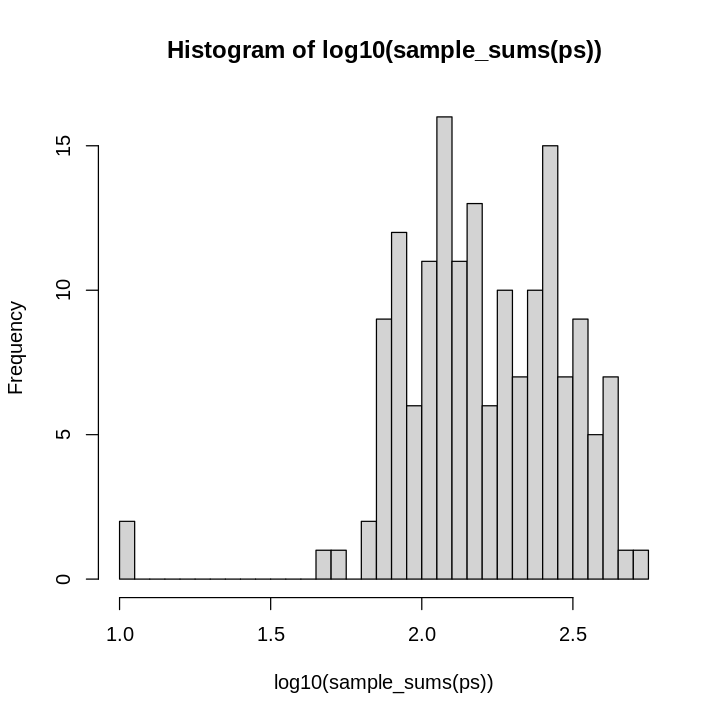

In [13]:
hist(log10(sample_sums(ps)), breaks = 50)

We can see that samples with number of reads $\leq 10 ^ {1.5}$ (i.e. < ~32) seem to be outliers. 
   Let's filter out the outliers and plot a new histogram.

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 909 taxa and 160 samples ]
sample_data() Sample Data:       [ 160 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 909 taxa by 7 taxonomic ranks ]

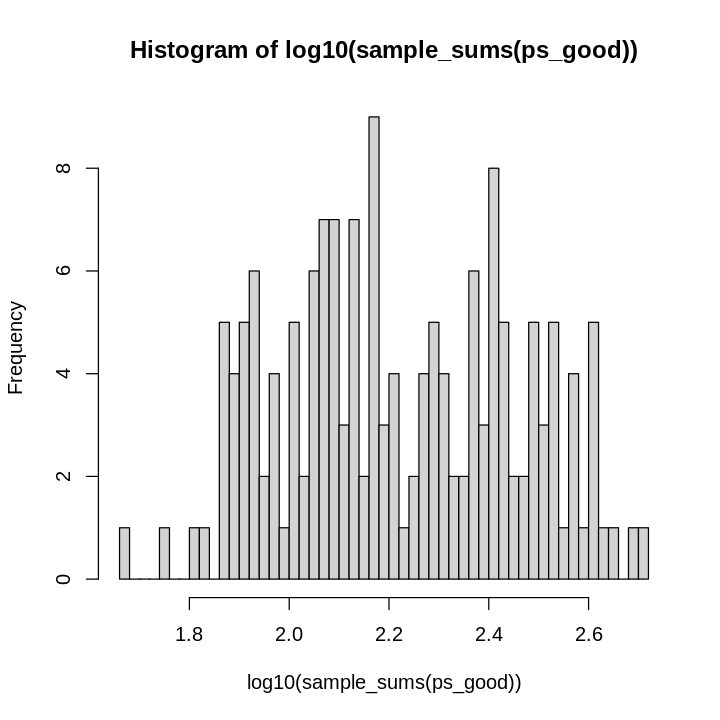

In [14]:
ps_good = subset_samples(ps, sample_sums(ps) > 32)
ps_good
hist(log10(sample_sums(ps_good)), breaks = 50)

And let's check how many samples were discarded:

In [15]:
nsamples(ps)
nsamples(ps_good)

[1] 162

[1] 160

2) Remove singletons existing in a single sample. Singletons are OTUs of size one, meaning that only one read was assigned to such OTU. These very low-abundant OTUs could be biologically real (belongs to the rare biosphere [1]), or they could be false positives due to sequencing artefacts. Singletons observed in one sample only are more likely to be of the later type, and is a good practice to remove them from the OTUs counts table to avoid an artificial OTUs richness over-estimation. You can find more discusssion about this in [Robert Edgar's blog](https://drive5.com/usearch/manual/singletons.html).

In [16]:
ps_final <- filter_taxa(ps_good, function(x) sum(x) > 1, prune=TRUE)
ps_final

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 589 taxa and 160 samples ]
sample_data() Sample Data:       [ 160 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 589 taxa by 7 taxonomic ranks ]

3) Show some stats on the sequencing depth across samples.

[1] "The max difference in sequencing depth is 11.1555555555556"

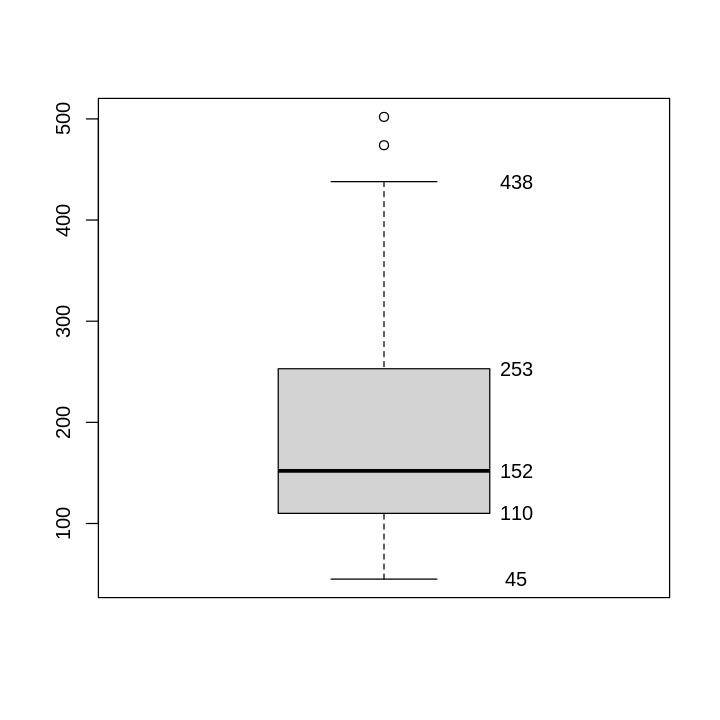

In [18]:
max_difference=max(sample_sums(ps_final))/min(sample_sums(ps_final))

sprintf("The max difference in sequencing depth is %s", max_difference)

boxplot(sample_sums(ps_final))
text(y = boxplot.stats(sample_sums(ps_final))$stats, labels = boxplot.stats(sample_sums(ps_final))$stats, x = 1.25)

A difference of a 10-fold change in the library sizes means that we will need to apply a normalization method before continuing with the analysis. The most common normalization methods used in microbiome count data are proportions and rarefaction. However, other methods originally developed to normalize RNA-seq counts have been adapted to differentially abundance analysis in microbiome data. A discussion about how to choose the right normalization method is out of the scope of this material, but the topic has been covered in multiple forums and scientific publications. Different methods could be more convenient than others depending on the downstream analysis we intend to perform. For instance, to compare at community-level through beta-diversity, "...proportions and rarefying produced more accurate comparisons among communities and are the only methods that fully normalized read depths across samples. Additionally, upper quartile, cumulative sum scaling (CSS), edgeR-TMM, and DESeq-VS often masked differences among communities when common OTUs differed, and they produced false positives when rare OTUs differed" [2]. On the other hand, for detection of differentially abundant species, "both proportions and rarefied counts result in a high rate of false positives in tests for species that are differentially abundant across sample classes" [3].


In the following examples we will show three popular ways of normalization: relative abundance, rarefaction and cummulative sum scaling.

### 2.2. Normalization by total sum scaling (TSS, relative abundance or proportions) <a id='part2_2'/>

The most simple way to normalize the differences in sample size is to transform the OTU counts table into relative abundance by dividing the number of total reads of each sample. This type of normalization is also referred to as relative abundance or proportions. We use this normalization to compare taxonomic profiles, while alpha diversity indices are computed on the non-normalized matrix. The reason to do so is that we need a matrix of integer numbers as input.

1) Compute alpha diversity indices and display plots.

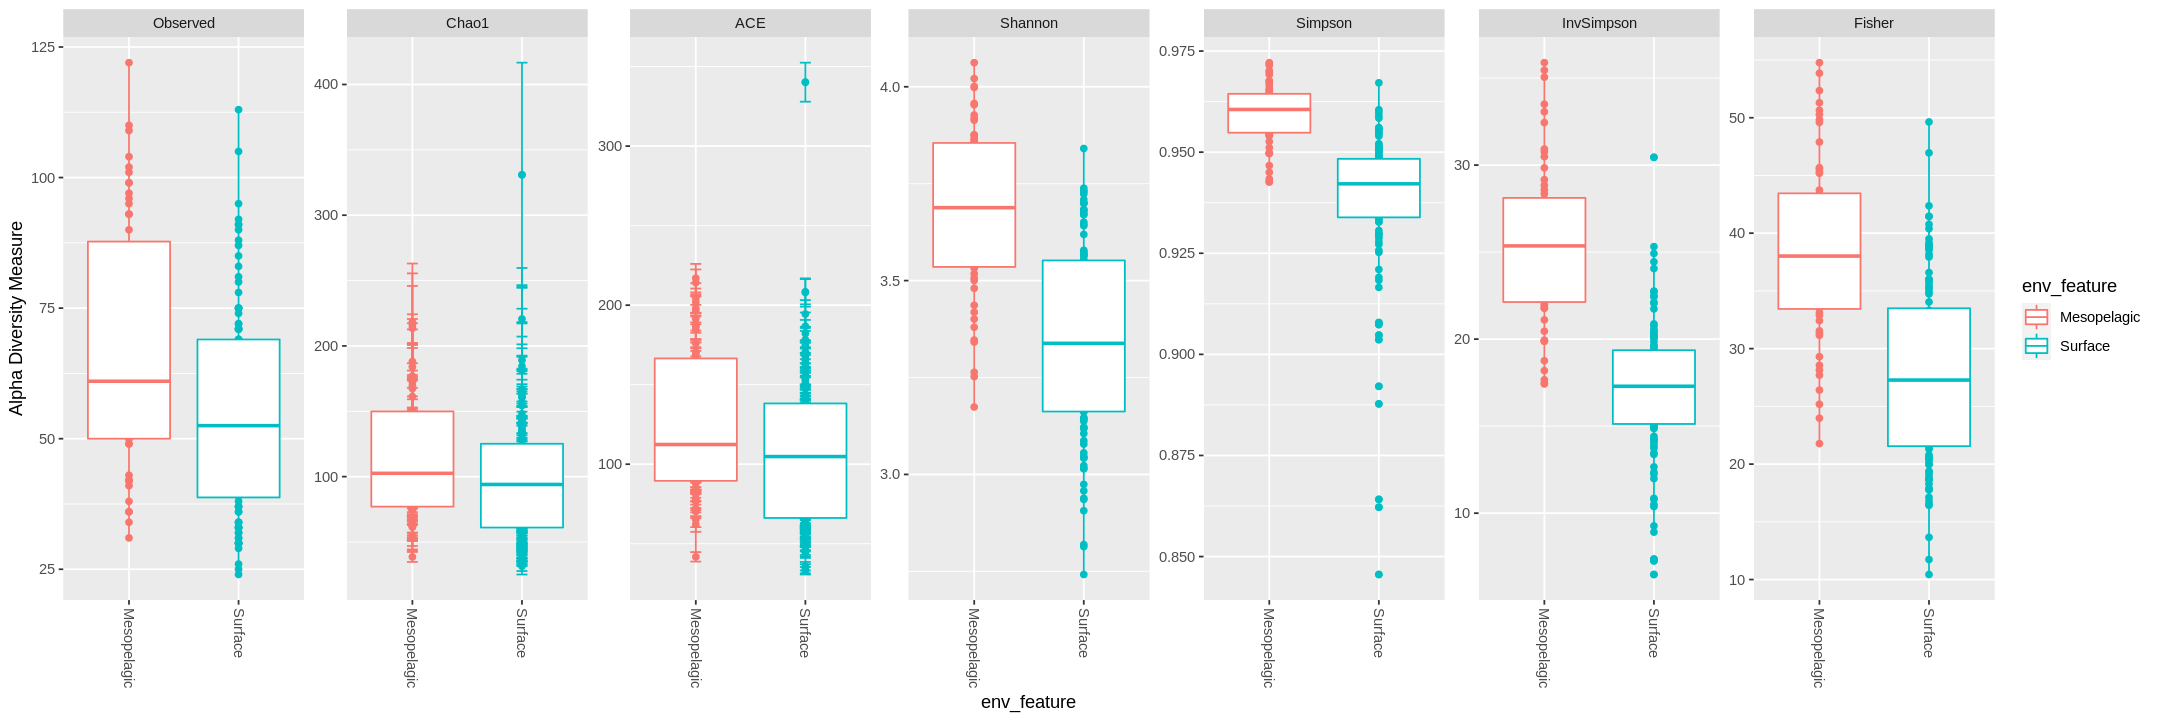

In [19]:
options(repr.plot.width=18, repr.plot.height=6)
plot_richness(ps_final, x = "env_feature", color = "env_feature") + geom_boxplot()

2) Transform taxonomy raw-counts matrix into relative abundance.

In [20]:
relab_ps = transform_sample_counts(ps_final, function(x) x/sum(x))

3) Agglomerate taxonomy at Class rank and keep only the most abundant classes (threshold=0.01%). In microbial data, we expect to observe abundance distributions with a long 'tail' of low-abundance organisms which often comprise the large majority of species. For this reason, once the matrix has been transformed to relative abundance, we will show the taxonomic profile at a high taxonomic rank (Class), agglomerating the counts first and using an abundance threshold of 0.01% to avoid displaying too many unreadable categories in the plot.

In [21]:
psglom = tax_glom(relab_ps, "Class")
norare_ps = filter_taxa(psglom, function(x) mean(x) > 0.01, TRUE)

4) Visualisation of the profile in barplots at Class rank in two visualization modes.

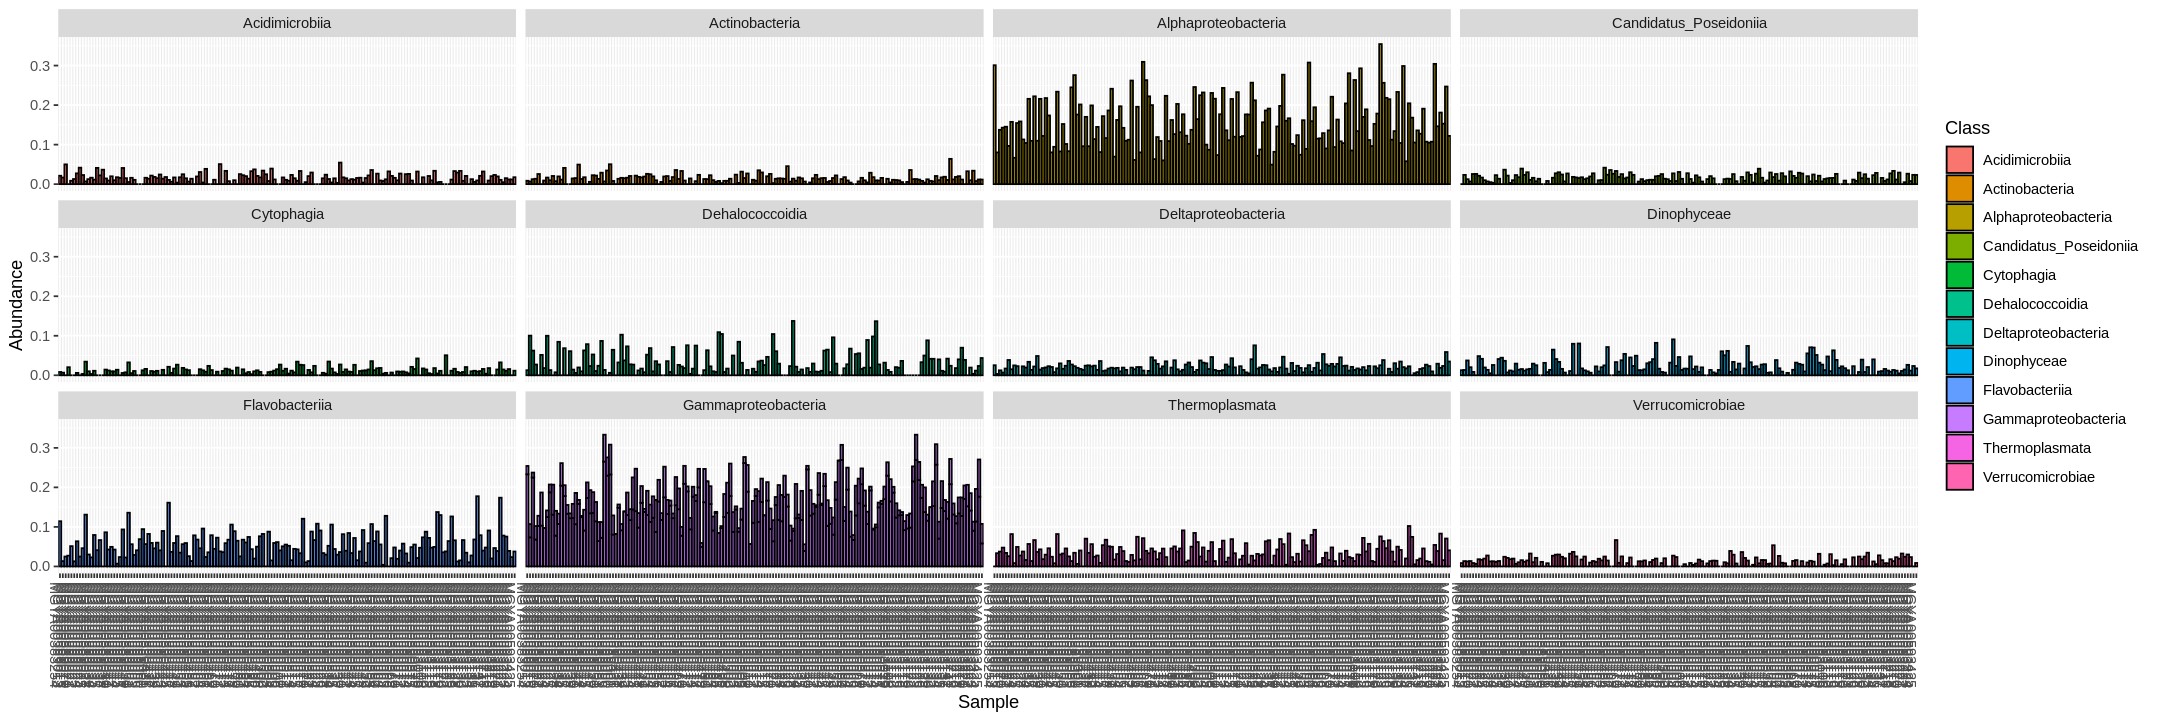

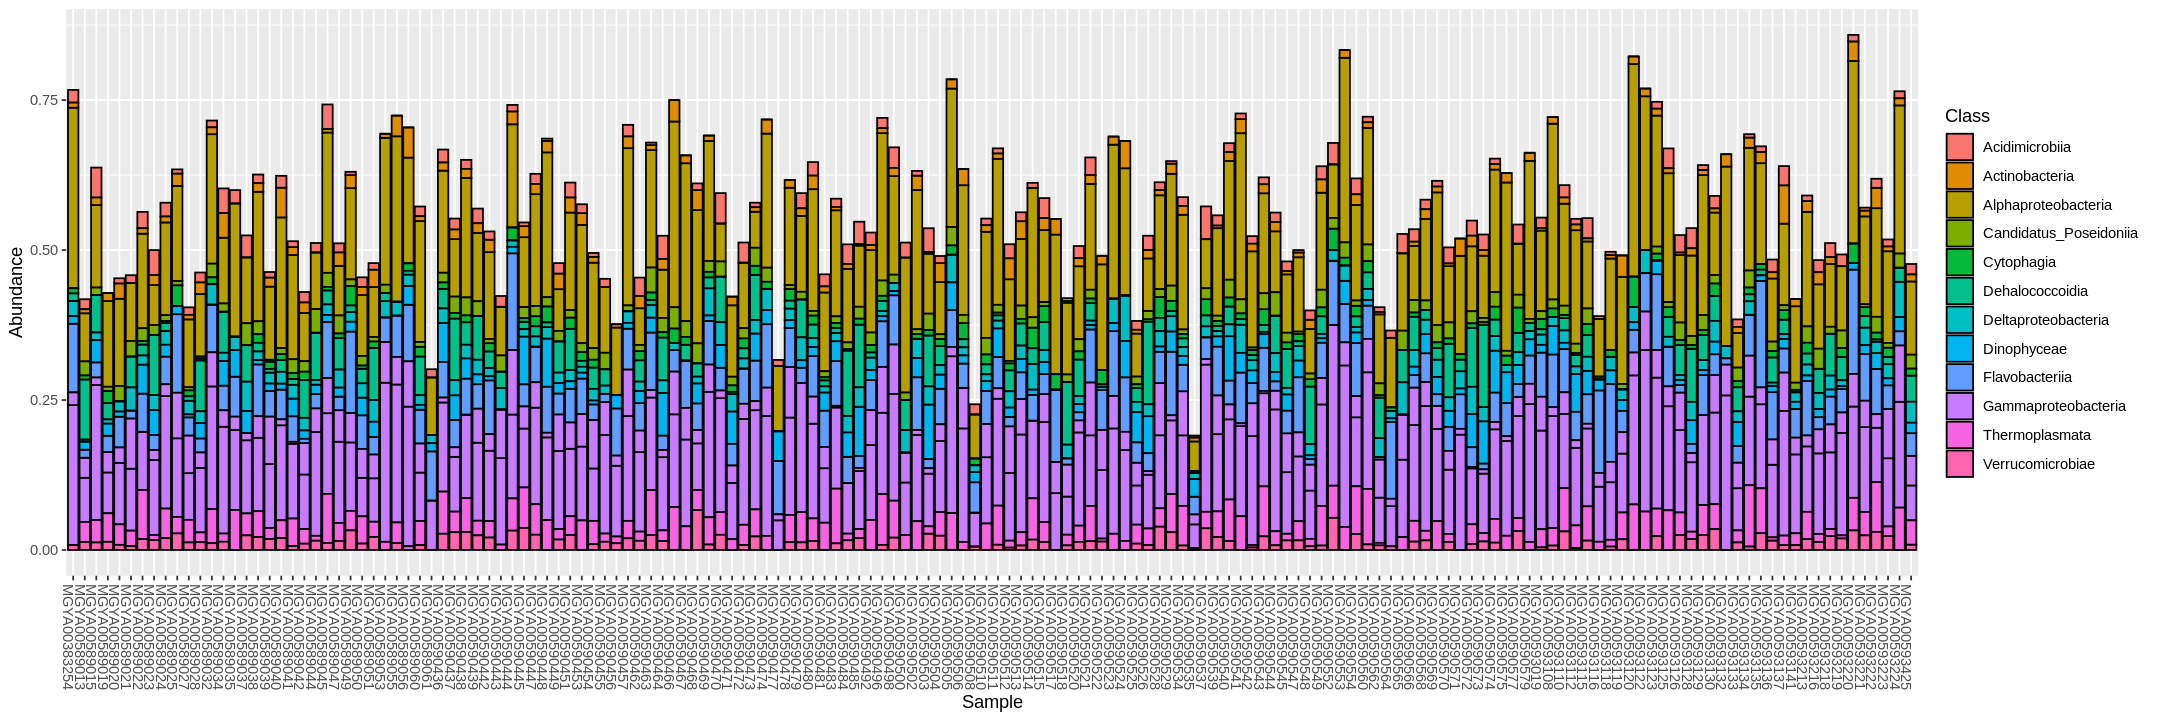

In [22]:
plot_bar(norare_ps, fill = "Class") + facet_wrap(~Class) 
plot_bar(norare_ps, fill = "Class")

### 2.3. Normalization by subsampling (rarefaction) <a id='part2_3'/>

Rarefaction is an alternative to relative abundance normalization to obtain an adjusted OTUs count matrix. The method is based on a process of subsampling to the smallest library size in the data set. The algorithm randomly removes reads until the samples reach the same library size. Despite the apparent disadvantage of discarding information from the larger samples, rarefaction is quite popular in microbial ecology.

The first step is to find the smallest sample size. We can use the number of observed otus in the original matrix to do so.

1) Find the smallest sample size.

In [23]:
head(estimate_richness(ps_final)[order(estimate_richness(ps_final)$Observed),], 1)

,Observed,Chao1,se.chao1,ACE,se.ACE,Shannon,Simpson,InvSimpson,Fisher
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MGYA00593120,24,31.5,6.343828,34.28079,2.887818,2.741841,0.9078673,10.85391,11.73299


2) Rarefying to the smallest sample.

In [24]:
ps_rare=rarefy_even_depth(ps_final, sample.size=24, replace = FALSE, rngseed=123, verbose = FALSE)
#otu_table(ps_rare)

3) Plot diversity indices.

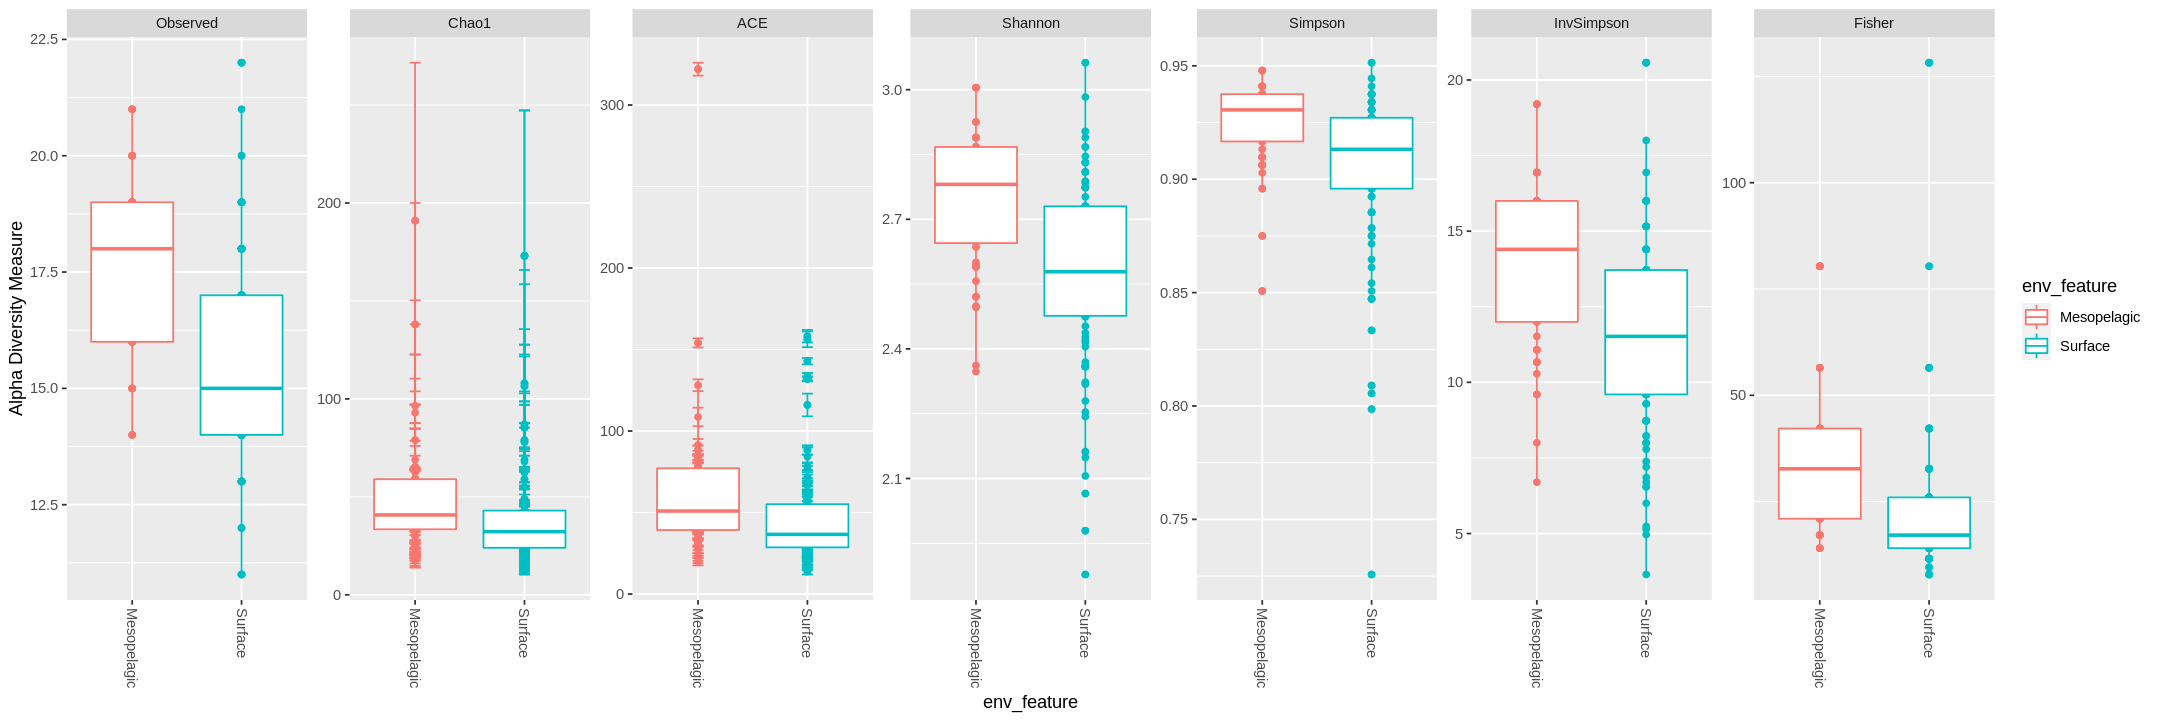

In [25]:
plot_richness(ps_rare, x = "env_feature", color = "env_feature") + geom_boxplot()

4) Aglomerate taxonomy at Class rank and visualize the profile (show the top 15 classes only).

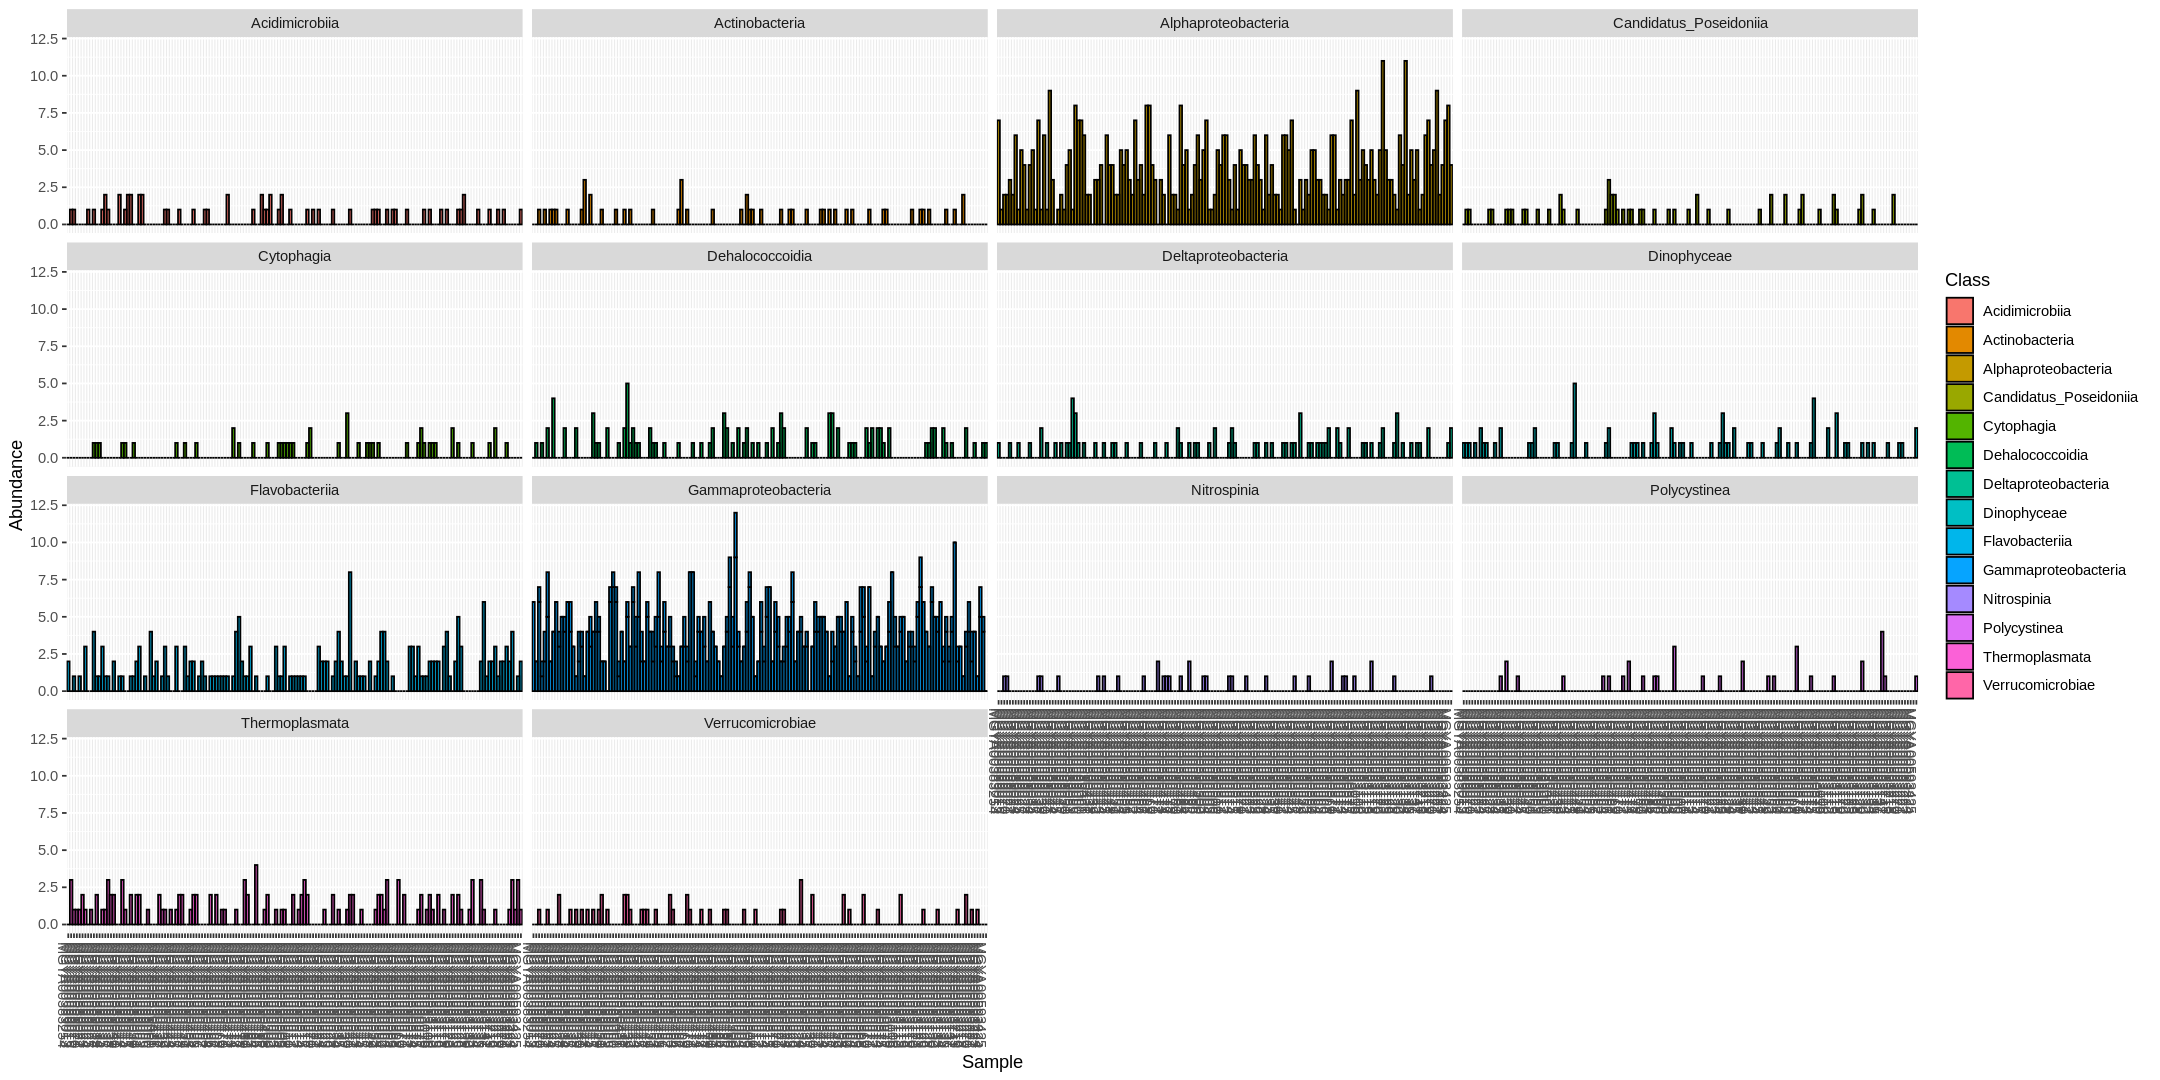

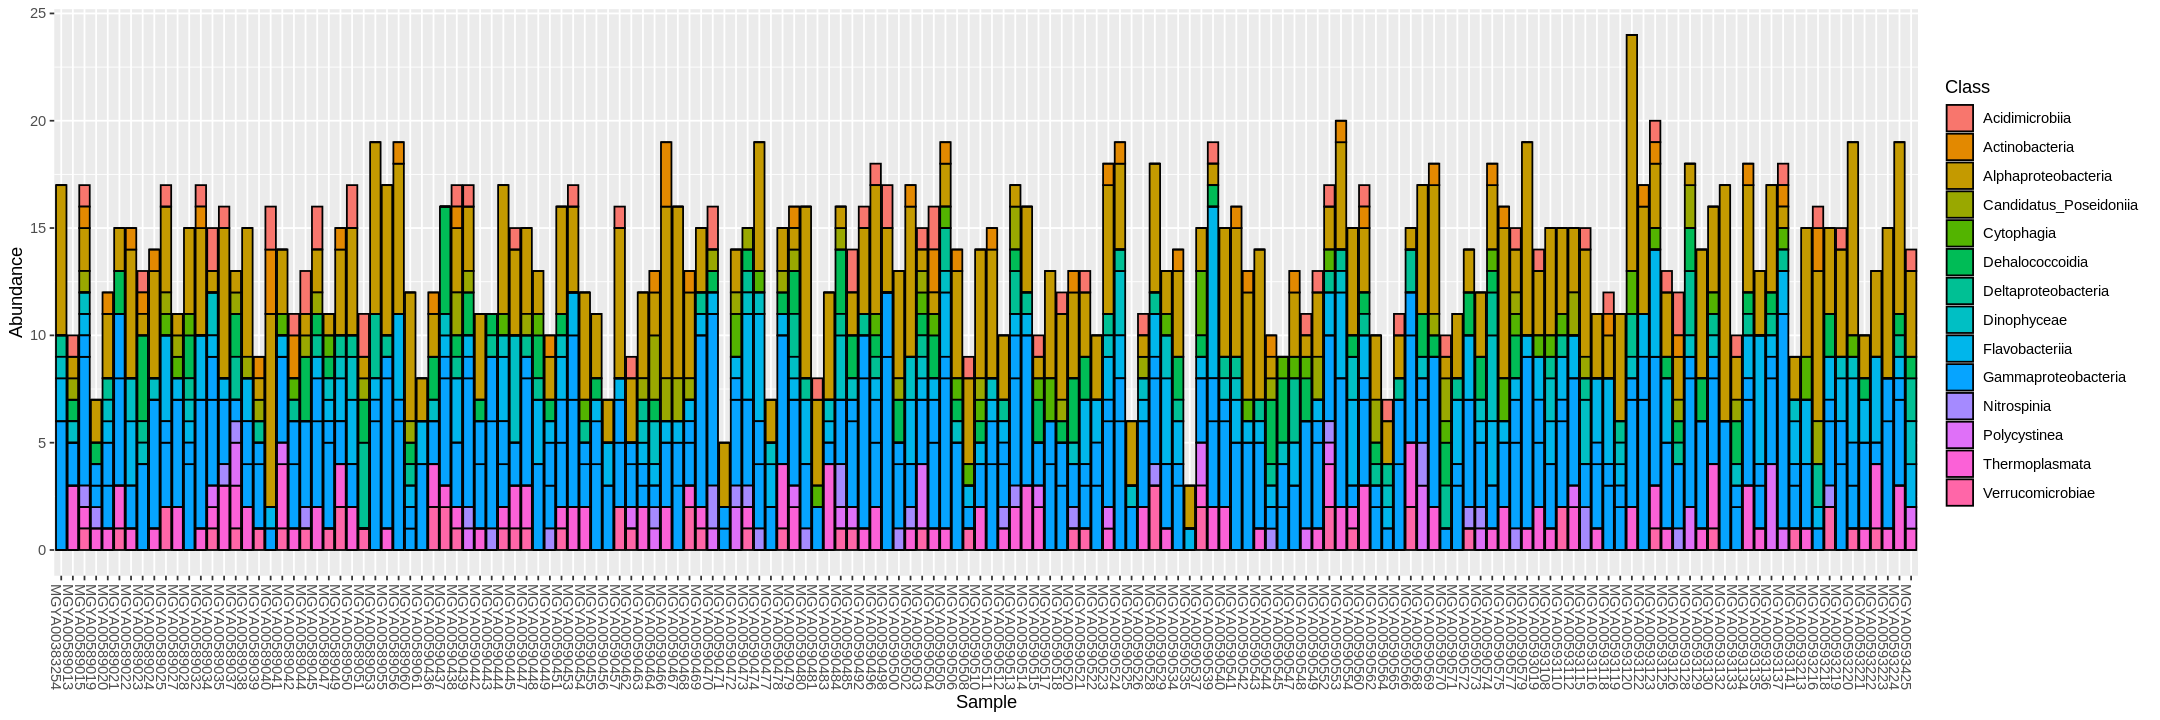

In [26]:
psglom = tax_glom(ps_rare, "Class")
top15 = names(sort(taxa_sums(psglom), decreasing=TRUE)[1:15])
top15_ps = prune_taxa(top15, psglom)

options(repr.plot.width=18, repr.plot.height=9)
plot_bar(top15_ps, fill = "Class") + facet_wrap(~Class)

options(repr.plot.width=18, repr.plot.height=6)
plot_bar(top15_ps, fill = "Class")

### 2.4. Normalization by cumulative sum scaling (CSS) <a id='part2_4'/>

The third normalization method we are going to apply is CSS. To do so, we will use the implementation on the microbiomeMarker library.
Cumulative sum scaling normalization calculates scaling factors as the cumulative sum of gene abundances up to a data-derived threshold. This method is based on the assumption that the count distributions in each sample are equivalent for low abundant genes up to a certain threshold. Only the segment of each sample's count distribution that
is relatively invariant across samples is scaled by CSS.

1) Normalizing the OTU counts in the ps_final object.

In [27]:
ps_CSS=normalize(ps_final, method = "CSS")

2) Compute and plot alpha diversity metrics.

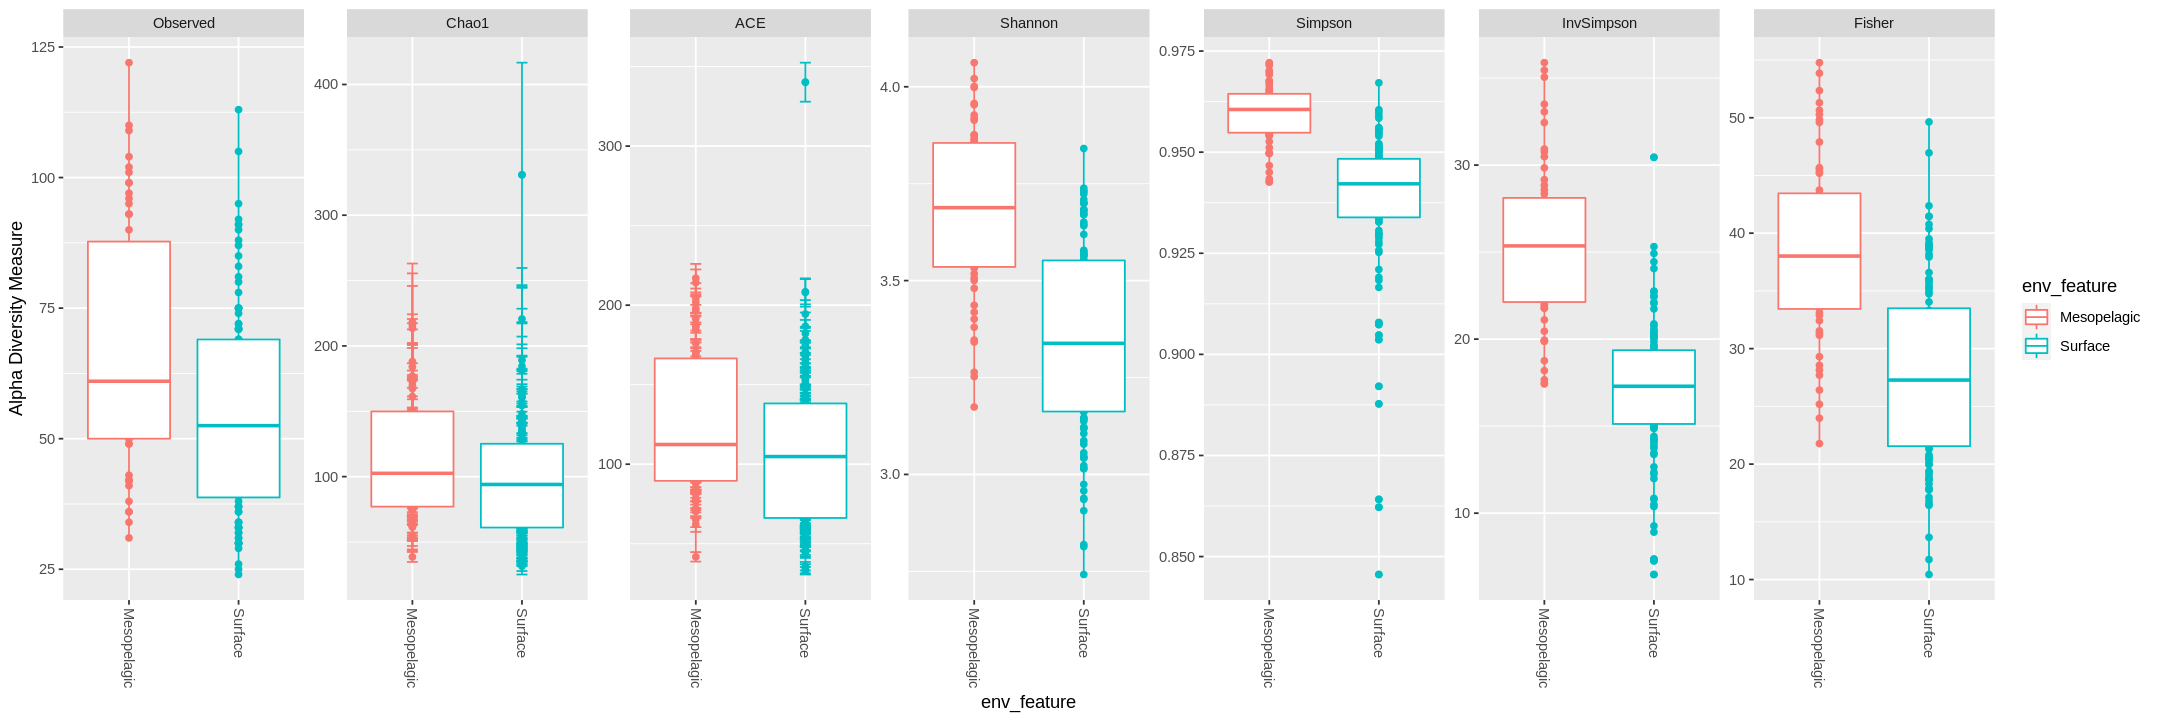

In [28]:
plot_richness(ps_CSS, x = "env_feature", color = "env_feature") + geom_boxplot()

3) Aglomerate taxonomy at Class rank and visualize the profile (show the top 15 classes only).

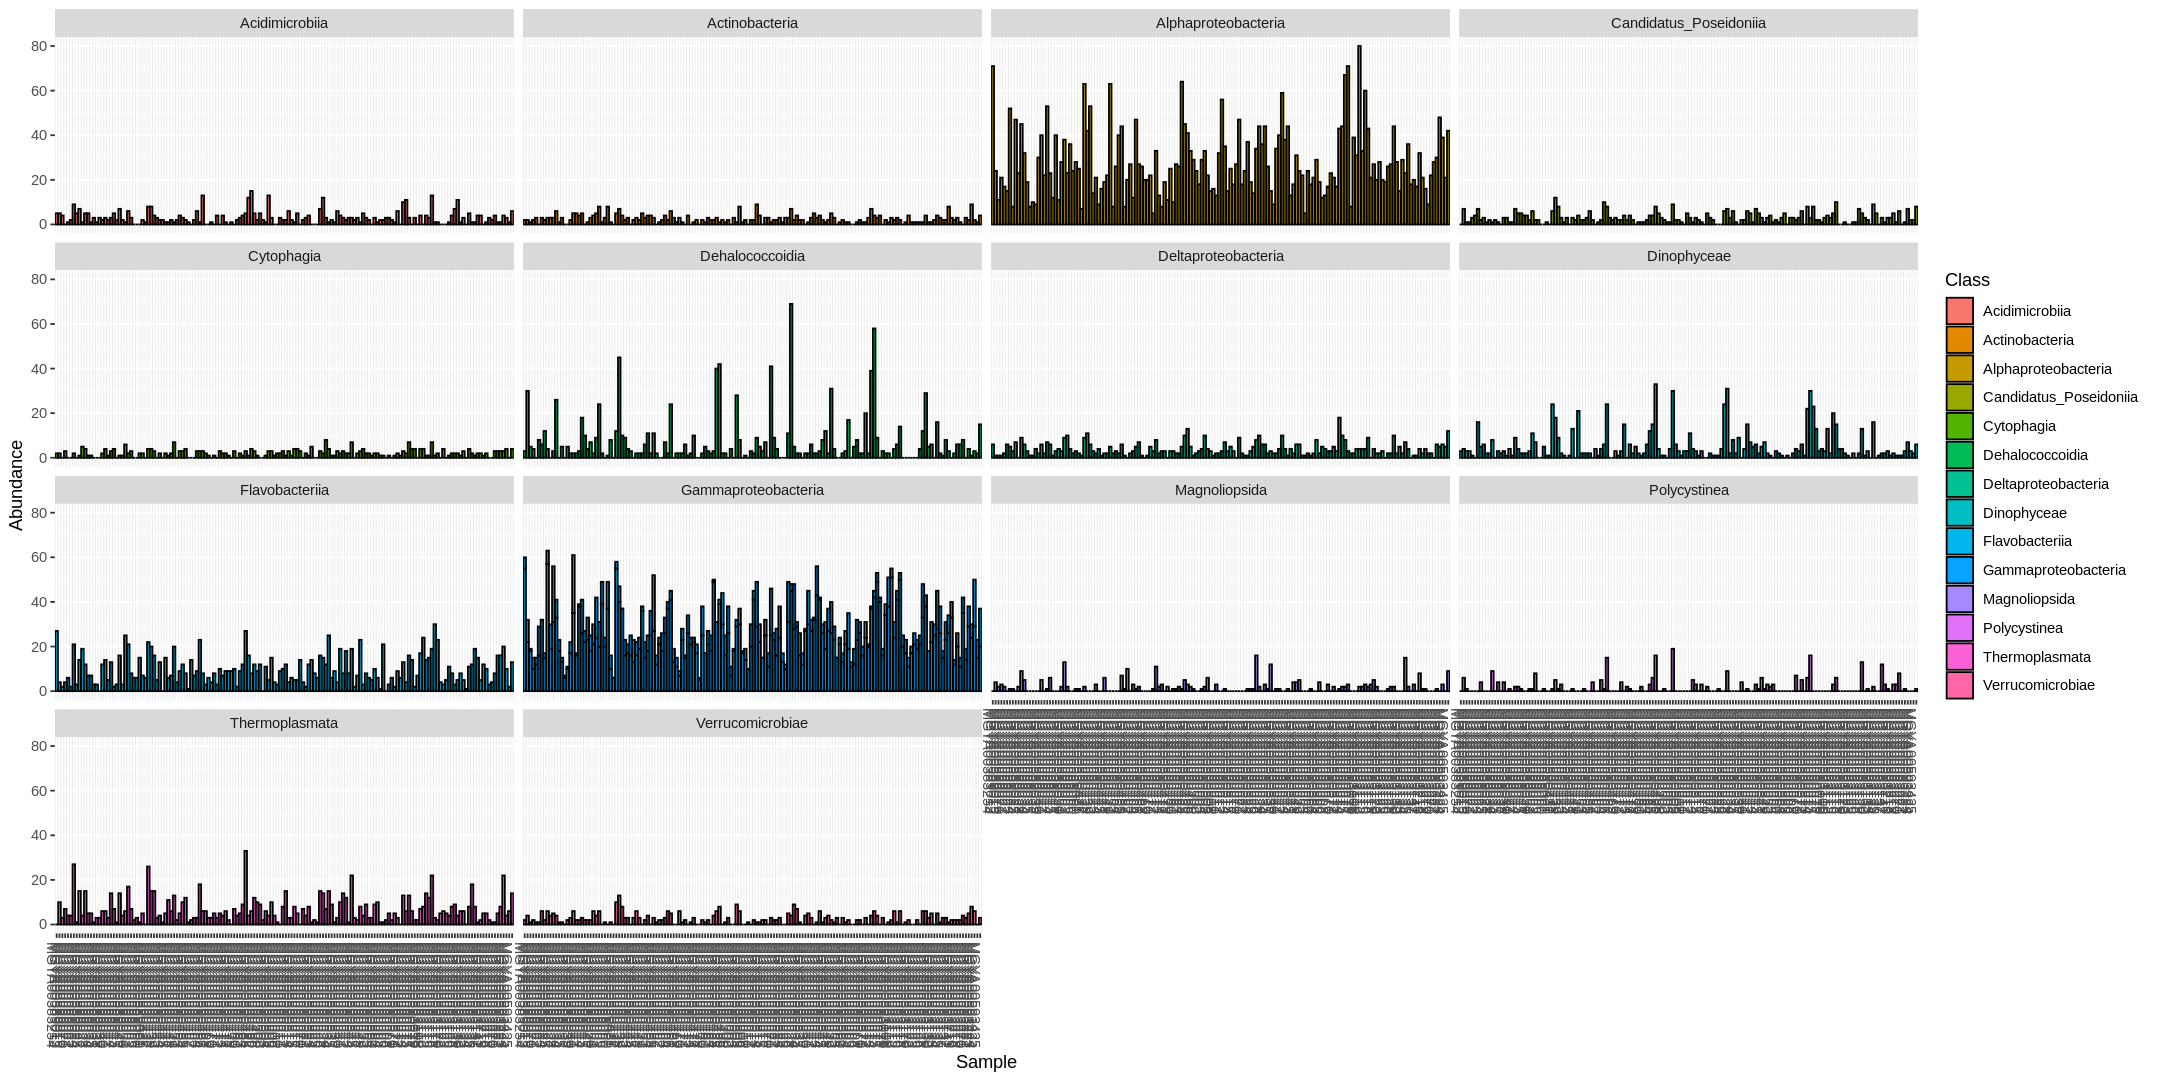

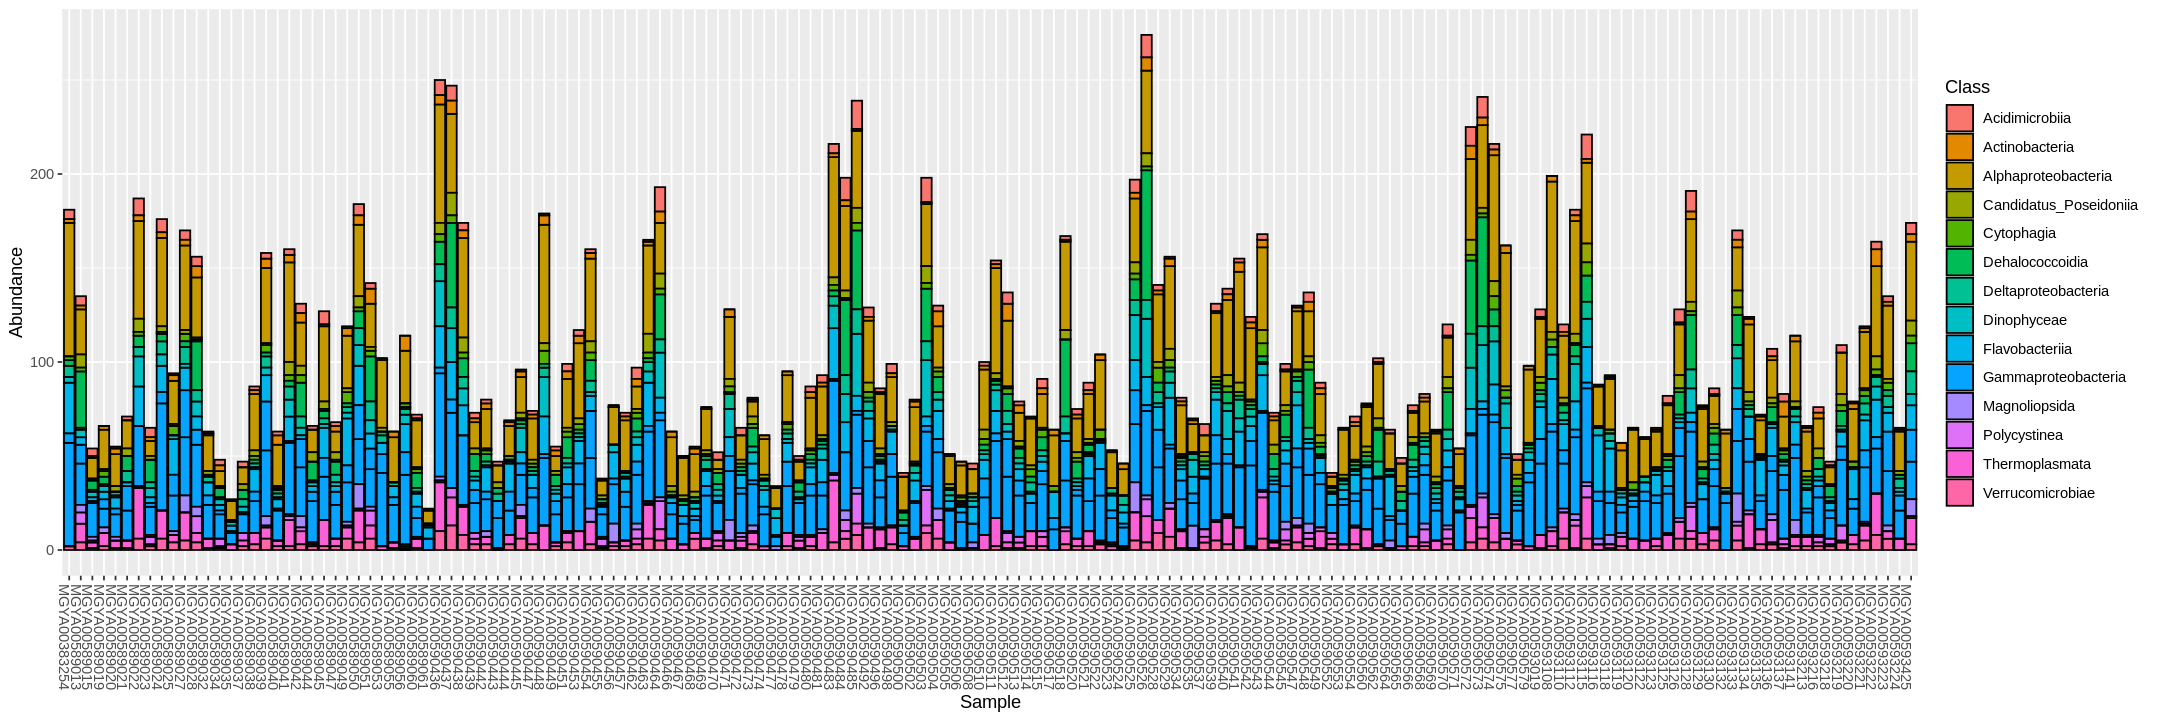

In [29]:
psglom = tax_glom(ps_CSS, "Class")
top15 = names(sort(taxa_sums(psglom), decreasing=TRUE)[1:15])
top15_ps = prune_taxa(top15, psglom)

options(repr.plot.width=18, repr.plot.height=9)
plot_bar(top15_ps, fill = "Class") + facet_wrap(~Class)

options(repr.plot.width=18, repr.plot.height=6)
plot_bar(top15_ps, fill = "Class")

## Part 3. Comparative metagenomics at community-level: Beta diversity <a id='part3'/>

According with Pereira *et al.,* (2018)[4], the best normalization method for metagenomic gene abundance (tested in TARA ocean samples) is CSS for large group sizes. For this reason, we will stick on this method to show beta-diversity.

1) Compute beta diversity using different methods to calculate distance and perform principle coordinates analysis ploting the first two axes. We will based on the steps described on [4] to create a list of suitable distance methods (included in the list of available methods in adonis options for the next step), iterate on them and display a combined plot. For a better visualization we are going to add an stat ellipse at 95% of confidence.

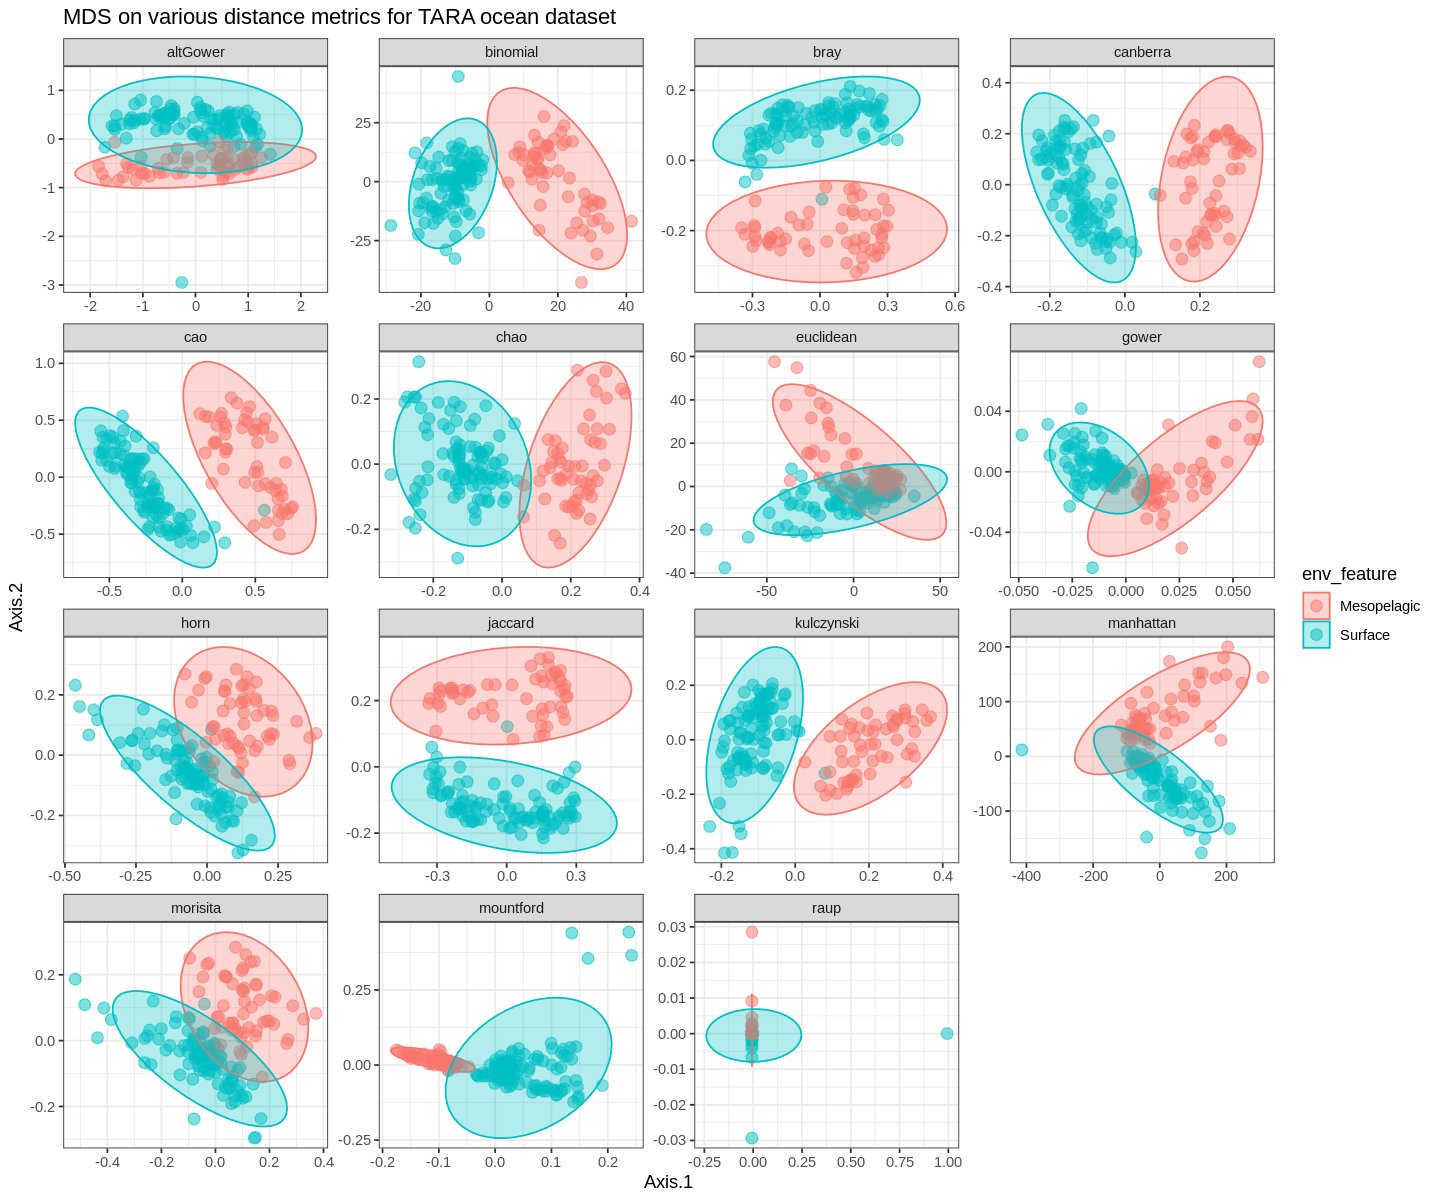

In [30]:
# Generating the methods list
dist_methods = unlist(distanceMethodList)
dist_methods = dist_methods[c(-(1:4),-(20:47))]

# Iterating through the list to save the plot
plist <- vector("list", length(dist_methods))
names(plist) = dist_methods
for( i in dist_methods ){
    # Calculate distance matrix
    iDist <- distance(ps_CSS, method=i)
    # Calculate ordination
    iMDS  <- ordinate(ps_CSS, "MDS", distance=iDist)
    ## Make plot
    # Don't carry over previous plot (if error, p will be blank)
    p <- NULL
    # Create plot, store as temp variable, p
    p <- plot_ordination(ps_CSS, iMDS, color="env_feature")
    # Add title to each plot
    p <- p + ggtitle(paste("MDS using distance method ", i, sep=""))
    # Save the graphic to file.
    plist[[i]] = p
}

# Create a combined plot
df = ldply(plist, function(x) x$data)
names(df)[1] <- "distance"
p = ggplot(df, aes(Axis.1, Axis.2, color=env_feature))
p = p + geom_point(size=3, alpha=0.5)
p = p + facet_wrap(~distance, scales="free")
p = p + ggtitle("MDS on various distance metrics for TARA ocean dataset") + stat_ellipse(level = 0.95, type="norm", geom = "polygon", alpha=0.3, aes(fill=env_feature)) + theme_bw()

options(repr.plot.width=12, repr.plot.height=10)
p

2) Select the best distance metric that segregates the data by water layer and determine whether the two groups of samples have different centroids. To do so, we use a permanova implemented in the Adonis function of vegan library. The method will calculates the squared deviations of each of site to the centroid and then, significance tests are performed using F-tests based on sequential sums of squares from permutations of the raw data.

In [31]:
metadata = as(sample_data(ps_CSS), "data.frame")
css_beta = distance(ps_CSS, method="canberra")

adonis(css_beta ~ env_feature, data = metadata, perm=1e3)


Call:
adonis(formula = css_beta ~ env_feature, data = metadata, permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

             Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)    
env_feature   1     4.602  4.6024  15.447 0.08906 0.000999 ***
Residuals   158    47.076  0.2980         0.91094             
Total       159    51.679                 1.00000             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

3) To discard differences detected by adonis due to variation in dispersion of the data. Finally we are going to run a betadisper test (also from vegan library) and to evaluate if there's a significant variation in beta dispersion between groups through an anova.

In [32]:
anova(betadisper(css_beta, metadata$'env_feature'))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,1,3.893589e-05,3.893589e-05,0.01403099,0.9058596
Residuals,158,4.384489e-01,2.774993e-03,NA,NA


With these results, we can now accept that there is a statistical difference between groups and it is not a false positive due to the data dispersion.
This analysis would make more sense when there's not a clear separation between groups.

An extra piece of analysis for comparative metagenomics based on the detection of differentially abundant OTUs using the SIAMCAT library is addressed in the Comparative_metagenomics_2 notebook. 

### References: <a id='refs'/>

[1] https://doi.org/10.1038/nrmicro3400

[2] https://doi.org/10.1111/2041-210X.13115

[3] https://doi.org/10.1371/journal.pcbi.1003531

[4] https://doi.org/10.1186/s12864-018-4637-6

[5] https://joey711.github.io/phyloseq/distance.html

Documentation and more MGnifyR code and exercises following the links in: https://beadyallen.github.io/MGnifyR/

Phyloseq tutorials available here: https://joey711.github.io/phyloseq/index.html
